# 音声データから特徴量マップを作成

In [79]:
import numpy as np
from scipy import signal
import scipy.signal
import scipy.io.wavfile as wav
from scipy import ndimage
from scipy.signal import spectrogram
from scipy.ndimage import zoom

import matplotlib.pyplot as plt
import librosa
import sounddevice as sd
import torch
import timm

### 1. 音声データの取得

In [55]:
def record_sound():
    print("Start recording...")
    sound_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()
    print("End recording.")
    return sound_data

def play_sound(sound_data):
    print("Start playing...")
    sd.play(sound_data, sample_rate)
    sd.wait()
    print("End playing.")

def save_sound(sound_data, filename):
    print("Start saving...")
    wav.write(filename, sample_rate, sound_data)
    print(f"End saving. Saved as {filename}.")

In [56]:
duration = 10  # 録音時間（秒）
sample_rate = 44100  # Hz

# 音声の録音
sound_data = record_sound()

Start recording...
End recording.


In [58]:
# 音声の再生
play_sound(sound_data)

Start playing...
End playing.


In [59]:
# 音声の保存
save_sound(sound_data, "sound_data.wav")

Start saving...
End saving. Saved as sound_data.wav.


### 2. スペクトログラムの作成

In [106]:
# 音声データの読み込み
sound_data, sample_rate = librosa.load('sound_data.wav', sr=44100)
# sound_data, sample_rate = librosa.load('sound_data_momo.wav', sr=44100)
print(sound_data.shape)

# スペクトログラムの取得
freq, time, spec = spectrogram(sound_data, fs=sample_rate, nperseg=1024, noverlap=512)
print(freq.shape, time.shape, spec.shape)
# スペクトログラムをデシベル単位に変換
spec_db = 10 * np.log10(spec)
# スペクトログラムを正規化
spec_norm = (spec_db - np.mean(spec_db)) / np.std(spec_db)

# 前処理
# クロップして正方形にする
min_dim = min(spec_norm.shape)
spec_norm_cropped = spec_norm[:min_dim, :min_dim]
# リサイズ
resize_ratio = (224/min_dim, 224/min_dim)  # 2つの値のみを使用する
spec_norm_resized = zoom(spec_norm_cropped, resize_ratio, order=1)
print(spec_norm_resized.shape)

(441000,)
(513,) (860,) (513, 860)
(224, 224)


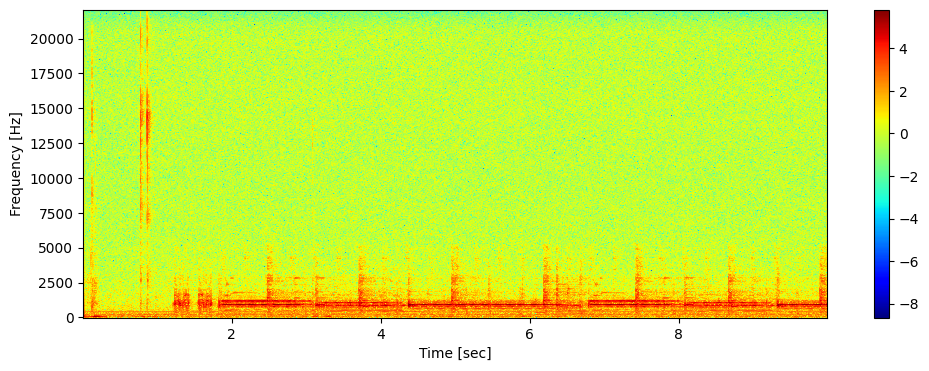

In [104]:
# 音声の再生
audio_widget = Audio(sound_data, rate=sample_rate, autoplay=True)
display(audio_widget)

# ヒートマップの表示
plt.figure(figsize=(12,4))
plt.pcolormesh(time, freq, spec_norm, cmap='jet')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]')
plt.colorbar()
plt.show()


### 3. torch_CNNへの適応と特徴量マップの取得

In [150]:

# PyTorchモデルの読み込み
model_names = ["resnet18", "resnet152", "resnet200", "efficientnet_b0", "swinv2_cr_small_ns_224"]
model = timm.create_model(model_names[4], pretrained=True)

# モデルの構造を表示
# print(model)
# モデルの深さを計算
num_layers = sum(1 for _ in model.modules() if isinstance(_, torch.nn.Conv2d))
print('Number of layers:', num_layers)
# モデルのパラメータ数を計算
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters:', num_params)


# 入力をPyTorchのテンソルに変換
spec_norm_resized_tensor = torch.tensor(spec_norm_resized).unsqueeze(0)
spec_norm_resized_tensor = spec_norm_resized_tensor.repeat(1, 3, 1, 1)

# モデルの評価モードに変更
model.eval()

# 特徴量マップの抽出
with torch.no_grad():
    print("spec_norm_resized_tensor: ",str(spec_norm_resized_tensor.shape))
    features = model(spec_norm_resized_tensor)
    print(features.shape)

# 特徴量マップをnumpy配列に変換
features_np = features.numpy()

# 特徴量マップの表示
print(features_np.shape)

    
# クラス分類の計算
softmax = torch.nn.Softmax(dim=1)
probabilities = softmax(features)

# 最も確率の高いクラスを取得
class_idx = torch.argmax(probabilities, dim=1)
print("分類結果：",str(class_idx))


C:\Users\kushi\python_venv\22_django4env39\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights-swinv2/swin_v2_cr_small_ns_224_iv-2ce90f8e.pth" to C:\Users\kushi/.cache\torch\hub\checkpoints\swin_v2_cr_small_ns_224_iv-2ce90f8e.pth


Number of layers: 1
Number of parameters: 49696444
spec_norm_resized_tensor:  torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
(1, 1000)
分類結果： tensor([905])


In [151]:
### timmのモデル一覧を表示
# import pprint
# model_names = timm.list_models(pretrained=True)
# pprint.pprint(model_names)

### B. 異常検出

### mahalanobisAD: 時間変化に適応しやすいが精度は悪く扱いづらい

In [167]:
# マハラノビス距離（分散共分散行列）で異常値の判定を行う。
# 対象のデータサイズが大きいとすごく時間がかかるので、短時間に区切って適応するべき。

import numpy as np
import librosa
from scipy.signal import spectrogram
from sklearn.covariance import EmpiricalCovariance
from tqdm import tqdm

# 訓練データのスペクトログラムを用いて共分散行列を計算
train_data, _ = librosa.load('sound_data_momo.wav', sr=44100)
_, _, train_spec = spectrogram(train_data, fs=44100, nperseg=1024, noverlap=512)
train_spec = train_spec.T  # 転置して時間方向に並べる
print(train_spec.shape)
cov = EmpiricalCovariance().fit(train_spec)

# 異常検知対象のスペクトログラム
sound_data, _ = librosa.load('sound_data.wav', sr=44100)
_, _, spec = spectrogram(sound_data, fs=44100, nperseg=1024, noverlap=512)
spec = spec.T  # 転置して時間方向に並べる

# 各スペクトログラムの行列をベクトル化
train_spec_vec = np.reshape(train_spec, (train_spec.shape[0]*train_spec.shape[1],))
spec_vec = np.reshape(spec, (spec.shape[0]*spec.shape[1],))


# mahalanobis距離の計算
mean = np.mean(train_spec_vec, axis=0)
diff = spec_vec - mean
print(diff.shape)
inv_cov = cov.precision_
mahalanobis_dist = []
for i in tqdm(range(len(diff))):
    dist = np.sqrt(np.dot(np.dot(diff[i], inv_cov), diff[i].T))
    mahalanobis_dist.append(dist)

# 閾値を設定して異常検知
threshold = np.mean(mahalanobis_dist) + 2*np.std(mahalanobis_dist)
anomaly_flag = np.where(mahalanobis_dist > threshold, 1, 0)


(515, 513)
(441180,)


  0%|                                                                                       | 0/441180 [00:00<?, ?it/s]C:\Users\kushi\AppData\Local\Temp\ipykernel_16504\3856237728.py:34: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt(np.dot(np.dot(diff[i], inv_cov), diff[i].T))
  0%|▏                                                                           | 792/441180 [00:02<19:11, 382.46it/s]


KeyboardInterrupt: 

### Patch-Core

In [171]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

class SpectrogramDataset(Dataset):
    def __init__(self, sound_data, sample_rate, nperseg, noverlap):
        freq, time, spec = spectrogram(sound_data, fs=sample_rate, nperseg=nperseg, noverlap=noverlap)
        self.spec = torch.tensor(spec.T) # transpose spec to have shape (time, freq)
        
    def __getitem__(self, index):
        return self.spec[index]
        
    def __len__(self):
        return len(self.spec)
        

class SpectrogramModel(nn.Module):
    def __init__(self):
        super(SpectrogramModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 128 * 257, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 128 * 257)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Hyperparameters
nperseg = 1024
noverlap = 512
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# Load data
sound_data, sample_rate = librosa.load('sound_data.wav', sr=44100)
dataset = SpectrogramDataset(sound_data, sample_rate, nperseg, noverlap)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = SpectrogramModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        inputs = data.float()
        # inputs = torch.from_numpy(spec).float().view(1, 1, spec.shape[0], spec.shape[1])
        labels = torch.zeros(batch_size, dtype=torch.long)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(dataloader)))


RuntimeError: shape '[-1, 1052672]' is invalid for input of size 880640

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

class SpectrogramDataset(Dataset):
    def __init__(self, sound_data, sample_rate, nperseg, noverlap):
        freq, time, spec = spectrogram(sound_data, fs=sample_rate, nperseg=nperseg, noverlap=noverlap)
        self.spec = torch.tensor(spec.T) # transpose spec to have shape (time, freq)
        
    def __getitem__(self, index):
        return self.spec[index]
        
    def __len__(self):
        return len(self.spec)
        

class SpectrogramModel(nn.Module):
    def __init__(self):
        super(SpectrogramModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc1 = nn.Linear(32 * 16 * 16, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = x.unsqueeze(1) # add channel dimension
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Hyperparameters
nperseg = 1024
noverlap = 512
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# Load data
sound_data, sample_rate = librosa.load('sound_data.wav', sr=44100)
dataset = SpectrogramDataset(sound_data, sample_rate, nperseg, noverlap)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = SpectrogramModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        inputs = data.float()
        labels = torch.zeros(batch_size, dtype=torch.long)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(dataloader)))
    
# Save model
torch.save(model.state_dict(), 'spectrogram_model.pth')
